## Start measurments

In [1]:
#%matplotlib notebook
import os, time, sys
import importlib
import tables as tb
import matplotlib.pyplot as plt
import numpy as np
import panda2.panda2 as panda2

import panda2.analysis.fitfunctions as fitfunc
import panda2.scans.injection_scan as injection_scan


# run "ping" command
!ping -c 1 192.168.10.16

# instancíate a Panda2 class
dut = panda2.Panda2()
# read yaml file and connect to FPGA
dut.init()
dut.set_sync(auto_sync=True)  ## do not delete this


PING 192.168.10.16 (192.168.10.16) 56(84) bytes of data.
64 bytes from 192.168.10.16: icmp_seq=1 ttl=64 time=0.100 ms

--- 192.168.10.16 ping statistics ---
1 packets transmitted, 1 received, 0% packet loss, time 0ms
rtt min/avg/max/mdev = 0.100/0.100/0.100/0.000 ms


2024-05-15 13:54:55,815 - basil.HL.RegisterHardwareLayer - [INFO    ] (MainThread) Initializing spi_inj (firmware version: 2), module basil.HL.spi, base_addr 0x10
2024-05-15 13:54:55,816 - basil.HL.RegisterHardwareLayer - [INFO    ] (MainThread) Initializing inj (firmware version: 1), module panda2.pulse_gen_div, base_addr 0x100
2024-05-15 13:54:55,817 - basil.HL.RegisterHardwareLayer - [INFO    ] (MainThread) Initializing sync (firmware version: 3), module basil.HL.pulse_gen, base_addr 0x140
2024-05-15 13:54:55,817 - basil.HL.RegisterHardwareLayer - [INFO    ] (MainThread) Initializing gate (firmware version: 3), module basil.HL.pulse_gen, base_addr 0x180
2024-05-15 13:54:55,818 - basil.HL.RegisterHardwareLayer - [INFO    ] (MainThread) Initializing ts_inj (firmware version: 1), module panda2.timestamp_div, base_addr 0x1c0
2024-05-15 13:54:55,818 - basil.HL.RegisterHardwareLayer - [INFO    ] (MainThread) Initializing gpio (firmware version: 0), module basil.HL.gpio, base_addr 0x200
20

## Change settings (global, tdac, comp_en/dis etc)

In [30]:
# define col, row
col, row = 14, 32
### configure chip and enable injection
dut.set_en_inj([col, row])

# this is for Injection card
dut.set_inj_amp(1.0)

# set ampout ON
dut.set_en_ampout([col])


### inj_n: number of pulses to be injected. 0=continuous injection
# 1 = 1 clock of 40MHz = 25ns
dut.set_inj(inj_n=100, inj_width=1024*8, inj_delay=1024*8, ext=True)
dut.inject()

## set all tdac to 0
dut.set_tdac(0, comp='both')
### slow comp
tdac1 = np.copy(dut.PixelConf['tdac1'])
tdac1[:, :] = 7    # until 7
dut.set_tdac(tdac1, comp='slow')
VDACTh2=150+26

##fast comp
#tdac0 = np.copy(dut.PixelConf['tdac0'])
tdac0[:, :] = 7    # until 7
dut.set_tdac(tdac0, comp='fast')
VDACTh=250 #150

# sets VDAC and DAC
dut.set_conf(VDACTh=VDACTh,  # fast comparator, 255= very high (alomost off)
             VDACTh2=VDACTh2, # slow comparator, ~128 =  a bit higher than VDACBL 
             VDACBL=102+26,  # base line ~100~128 
             VNComp=10, # default =10
             VNComp2=0,
             VN=32, 
             INFoll2=20, 
             hidrEnB=1,   #1 disalbe, 0 enalbe
             IBLRes=1,    # R of Bl
             IPDAC=16,   # step of TDAC default default value=8, TDAC off = 0, 
                        # TDAC=7 no offset, TDAC=0 max negative offset
            )  ## set lowest (largest in number) threshold
            # IPDAC until 63
# sets comparator 
en_comp = np.copy(dut.PixelConf['en_comp0'])
### set all comp off
en_comp[:,:] = 0
dut.set_en_comp(en_comp, comp='both')
### set comp1 col=10, row=0 ON
en_comp[col, row] = 1
dut.set_en_comp(en_comp, comp='fast')
                #comp='slow')  ## 0= fast comp, 1 = slow

dut.set_en_hitbus([col])

# set_sync: set SyncRes
dut.set_sync(auto_sync=True)

# set timestamp module ON
dut.set_ts_inj(True)

# set the data reciever ON
dut.set_rx(True)
# but mask data for this moment
dut.mask_rx(True)


2024-05-15 14:47:04,256 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00004000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00001_00000_00000_00000_00000_00000_00000
2024-05-15 14:47:04,257 - root - [INFO    ] (MainThread) inj_amp: 4573
2024-05-15 14:47:04,260 - root - [INFO    ] (MainThread) set_en_ampout: en_ampout_col=0x00004000
2024-05-15 14:47:04,266 - root - [INFO    ] (MainThread) set_inj: inj_width=8192 inj_delay=8192 inj_phase=-1 inj_n=100 ext=1
2024-05-15 14:47:04,274 - root - [INFO    ] (MainThread) _write_conf row0 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-15 14:47:04,282 - root - [INFO    ] (MainThread) _write_conf row1 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7

2024-05-15 14:47:04,545 - root - [INFO    ] (MainThread) _write_conf row37 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-15 14:47:04,554 - root - [INFO    ] (MainThread) _write_conf row38 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-15 14:47:04,564 - root - [INFO    ] (MainThread) _write_conf row39 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-15 14:47:04,573 - root - [INFO    ] (MainThread) _write_conf row40 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-15 14:47:04,581 - root - [INFO    ] (MainThread) _write_conf row41 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7

## S-curve scan

2024-05-15 13:55:54,714 - root - [WARNING ] (MainThread) set_inj_amp: fail to set inj_amp=-87DAU, inj_amp must be 0-1.8V(9830DAU)
2024-05-15 13:55:54,716 - root - [INFO    ] (MainThread) inj_amp: 0
2024-05-15 13:55:54,716 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-15 13:55:54,717 - root - [INFO    ] (MainThread) Scan start time: 2024-05-15_13:55:54
2024-05-15 13:55:54,766 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500
2024-05-15 13:55:54,893 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 0
2024-05-15 13:55:55,138 - root - [INFO    ] (MainThread) Received words: 0
2024-05-15 13:55:55,139 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-15 13:55:55,140 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-15 13:55:55,141 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-15 13:55:55,142 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-1

2024-05-15 13:56:01,480 - root - [INFO    ] (MainThread) alingned to timestamp /home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/injection_scan/20240515_135554_injection_hit.h5


0.24s 18282/18282 hit=1498 ts=3600
th=0.123 th_sigma=0.003 Vinj


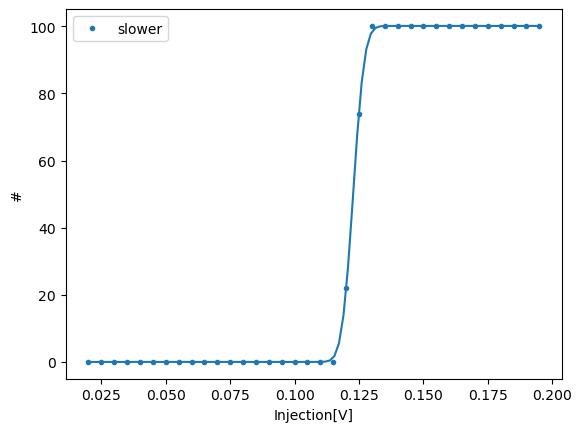

In [6]:
### only one selected pixel

dut.set_inj_amp(0.001, 'V')  # set amp to 200mV  
scan = injection_scan.InjectionScan(dut=dut)
fraw = scan.start(inj=np.arange(0.02, 0.2, 0.005), 
                  cols=None, 
                  rows=None)
fhit = scan.analyze()


## get data from hit file (event_data)
with tb.open_file(fhit) as f:
    dat = f.root.event_data[:]
## get data from raw data (scan_parameters)
with tb.open_file(fraw) as f:
    param = f.root.scan_parameters[:]

## select hits from comparator0
dat0 = dat[dat['comp']==0]
if len(dat0)!=0:
    ## take only the first data (delete hits from the rising edges)
    uni, idx= np.unique(dat0['timestamp'], return_index=True)
    dat0 = dat0[idx]
    ## count hits per event_number
    nhit = np.bincount(dat0['event_number'])

    # make a plot (injection vs n of hits)
    plt.plot(param['inj'], nhit, '.', label='faster')

## select hits from comparator1
dat1 = dat[dat['comp']==1]
if len(dat1)!=0:
#print(dat1)
    uni, idx = np.unique(dat1['timestamp'], return_index=True)
    dat1 = dat1[idx]
    nhit1 = np.bincount(dat1['event_number']) #, minlength=len(param))
    fit = fitfunc.fit_scurve(param['inj'], nhit1, reverse=False)
    x = np.linspace(np.min(param['inj']), np.max(param['inj']), num=100)
    plt.plot(x, fitfunc.scurve(x,*fit[:3]), '-')
    plt.plot(param['inj'], nhit1, 'C0.', label='slower')

## show x-axis and y-axis and legend
plt.xlabel('Injection[V]')
plt.ylabel('#')
plt.legend()

## print threshold
print('th={0:.3f} th_sigma={1:.3f} Vinj'.format(fit[1], fit[2]))




In [7]:
## run this if something was wrong
scan.close()


NameError: name 'scan' is not defined

### Multiple pixels

In [31]:
## 9 pixels
for col in [14,15,16]:
    for row in [30,31,32]:
        dut.mask_rx(True)
        ## enable comp
        en_comp[:,:] = 0
        en_comp[col, row] = 1
        dut.set_en_comp(en_comp, comp='slow')  ## 0= fast comp, 1 = slow
        ## enable inj
        dut.set_en_inj([col, row])
        ## start scan
        dut.set_inj_amp(0.001, 'V')  # set amp to 200mV  
        scan = injection_scan.InjectionScan(dut=dut)
        fraw = scan.start(inj=np.arange(0.02, 0.2, 0.005), 
                          cols=None, 
                          rows=None)
        fhit = scan.analyze()

2024-05-15 14:47:59,721 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-15 14:47:59,727 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-15 14:47:59,731 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00004000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_10000_00000_00000_00000_00000_00000_00000
2024-05-15 14:47:59,731 - root - [WARNING ] (MainThread) set_inj_amp: fail to set inj_amp=-87DAU, inj_amp must be 0-1.8V(9830DAU)
2024-05-15 14:47:59,732 - root - [INFO    ] (MainThread) inj_amp: 0
2024-05-15 14:47:59,733 - root - [INFO    ] (MainThread) Initializing Injection

2024-05-15 14:48:06,387 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-15 14:48:06,387 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-15 14:48:06,448 - root - [INFO    ] (MainThread) Scan end time: 2024-05-15_14:48:06
2024-05-15 14:48:06,448 - root - [INFO    ] (MainThread) Total scan time: 7 seconds
2024-05-15 14:48:06,448 - root - [INFO    ] (MainThread) Data Output Filename: /home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/injection_scan/20240515_144759_injection_scan.h5
2024-05-15 14:48:06,696 - root - [INFO    ] (MainThread) interpreted /home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/injection_scan/20240515_144759_injection_hit.h5
2024-05-15 14:48:06,700 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=5
2024-05-15 14:48:06,700 - root - [INFO    ] (MainThread) 0.00s hit=1520/1520 event=1515 ts=3600/3600
2024-05-15 14:48:06,701 - root - [INFO    ] (MainThread) alingned to timestamp /home/hzhang/

0.24s 18381/18381 hit=1520 ts=3600


2024-05-15 14:48:07,330 - root - [INFO    ] (MainThread) Received words: 0
2024-05-15 14:48:07,331 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-15 14:48:07,332 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-15 14:48:07,333 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-15 14:48:07,334 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-15 14:48:07,335 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-15 14:48:07,337 - root - [INFO    ] (MainThread) starting scan nsteps=36
2024-05-15 14:48:07,340 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-15 14:48:07,473 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-15 14:48:07,478 - root - [INFO    ] (MainThread) inj_amp: 84
2024-05-15 14:48:07,643 - root - [INFO    ] (MainThread) InjectionScan: step=1 ts=300 hit=0
2024-05-15 14:48:07,648 - root - [INFO    ] (MainThread) inj_amp: 119
2024-05-15 14:48:07,812 - root - [

2024-05-15 14:48:13,657 - root - [WARNING ] (MainThread) set_inj_amp: fail to set inj_amp=-87DAU, inj_amp must be 0-1.8V(9830DAU)
2024-05-15 14:48:13,658 - root - [INFO    ] (MainThread) inj_amp: 0
2024-05-15 14:48:13,658 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-15 14:48:13,658 - root - [INFO    ] (MainThread) Scan start time: 2024-05-15_14:48:13
2024-05-15 14:48:13,701 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500


0.22s 17150/17150 hit=1270 ts=3600


2024-05-15 14:48:13,867 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 8
2024-05-15 14:48:14,293 - root - [INFO    ] (MainThread) Received words: 0
2024-05-15 14:48:14,295 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-15 14:48:14,296 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-15 14:48:14,297 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-15 14:48:14,298 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-15 14:48:14,299 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-15 14:48:14,301 - root - [INFO    ] (MainThread) starting scan nsteps=36
2024-05-15 14:48:14,303 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-15 14:48:14,435 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-15 14:48:14,440 - root - [INFO    ] (MainThread) inj_amp: 84
2024-05-15 14:48:14,604 - root - [INFO    ] (MainThread) InjectionScan: step=1 ts=300 hit=0
2024-05-15 14:48:

2024-05-15 14:48:20,635 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-15 14:48:20,638 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00008000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_10000_00000_00000_00000_00000_00000_00000
2024-05-15 14:48:20,638 - root - [WARNING ] (MainThread) set_inj_amp: fail to set inj_amp=-87DAU, inj_amp must be 0-1.8V(9830DAU)
2024-05-15 14:48:20,639 - root - [INFO    ] (MainThread) inj_amp: 0
2024-05-15 14:48:20,639 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-15 14:48:20,639 - root - [INFO    ] (MainThread) Scan start time: 2024-05-15_14:48:20
2024-05-15 14:48:20,681 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0

0.24s 18493/18493 hit=1540 ts=3600


2024-05-15 14:48:21,243 - root - [INFO    ] (MainThread) Received words: 0
2024-05-15 14:48:21,245 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-15 14:48:21,246 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-15 14:48:21,247 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-15 14:48:21,248 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-15 14:48:21,250 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-15 14:48:21,251 - root - [INFO    ] (MainThread) starting scan nsteps=36
2024-05-15 14:48:21,254 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-15 14:48:21,388 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-15 14:48:21,394 - root - [INFO    ] (MainThread) inj_amp: 84
2024-05-15 14:48:21,549 - root - [INFO    ] (MainThread) InjectionScan: step=1 ts=300 hit=0
2024-05-15 14:48:21,554 - root - [INFO    ] (MainThread) inj_amp: 119
2024-05-15 14:48:21,719 - root - [

2024-05-15 14:48:27,586 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00008000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00100_00000_00000_00000_00000_00000_00000
2024-05-15 14:48:27,587 - root - [WARNING ] (MainThread) set_inj_amp: fail to set inj_amp=-87DAU, inj_amp must be 0-1.8V(9830DAU)
2024-05-15 14:48:27,587 - root - [INFO    ] (MainThread) inj_amp: 0
2024-05-15 14:48:27,588 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-15 14:48:27,588 - root - [INFO    ] (MainThread) Scan start time: 2024-05-15_14:48:27
2024-05-15 14:48:27,638 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500


0.23s 17930/17930 hit=1426 ts=3600


2024-05-15 14:48:27,800 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 16
2024-05-15 14:48:28,227 - root - [INFO    ] (MainThread) Received words: 0
2024-05-15 14:48:28,228 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-15 14:48:28,229 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-15 14:48:28,230 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-15 14:48:28,231 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-15 14:48:28,233 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-15 14:48:28,235 - root - [INFO    ] (MainThread) starting scan nsteps=36
2024-05-15 14:48:28,237 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-15 14:48:28,371 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-15 14:48:28,377 - root - [INFO    ] (MainThread) inj_amp: 84
2024-05-15 14:48:28,533 - root - [INFO    ] (MainThread) InjectionScan: step=1 ts=300 hit=0
2024-05-15 14:48

2024-05-15 14:48:34,544 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00008000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00001_00000_00000_00000_00000_00000_00000
2024-05-15 14:48:34,544 - root - [WARNING ] (MainThread) set_inj_amp: fail to set inj_amp=-87DAU, inj_amp must be 0-1.8V(9830DAU)
2024-05-15 14:48:34,545 - root - [INFO    ] (MainThread) inj_amp: 0
2024-05-15 14:48:34,546 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-15 14:48:34,546 - root - [INFO    ] (MainThread) Scan start time: 2024-05-15_14:48:34
2024-05-15 14:48:34,601 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500


0.21s 17028/17028 hit=1250 ts=3600


2024-05-15 14:48:34,752 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 32
2024-05-15 14:48:35,196 - root - [INFO    ] (MainThread) Received words: 0
2024-05-15 14:48:35,197 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-15 14:48:35,199 - root - [INFO    ] (MainThread) SRAM FIFO size: 4
2024-05-15 14:48:35,200 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-15 14:48:35,202 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-15 14:48:35,203 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-15 14:48:35,204 - root - [WARNING ] (MainThread) SRAM FIFO not empty when starting FIFO readout: size = 4
2024-05-15 14:48:35,207 - root - [INFO    ] (MainThread) starting scan nsteps=36
2024-05-15 14:48:35,209 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-15 14:48:35,341 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=1
2024-05-15 14:48:35,347 - root - [INFO    ] (MainThread) inj_am

2024-05-15 14:48:41,566 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-15 14:48:41,569 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00010000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_10000_00000_00000_00000_00000_00000_00000
2024-05-15 14:48:41,569 - root - [WARNING ] (MainThread) set_inj_amp: fail to set inj_amp=-87DAU, inj_amp must be 0-1.8V(9830DAU)
2024-05-15 14:48:41,570 - root - [INFO    ] (MainThread) inj_amp: 0
2024-05-15 14:48:41,570 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-15 14:48:41,570 - root - [INFO    ] (MainThread) Scan start time: 2024-05-15_14:48:41
2024-05-15 14:48:41,620 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0

0.26s 19084/19084 hit=1665 ts=3600


2024-05-15 14:48:42,188 - root - [INFO    ] (MainThread) Received words: 0
2024-05-15 14:48:42,189 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-15 14:48:42,190 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-15 14:48:42,192 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-15 14:48:42,193 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-15 14:48:42,194 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-15 14:48:42,197 - root - [INFO    ] (MainThread) starting scan nsteps=36
2024-05-15 14:48:42,200 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-15 14:48:42,334 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-15 14:48:42,340 - root - [INFO    ] (MainThread) inj_amp: 84
2024-05-15 14:48:42,497 - root - [INFO    ] (MainThread) InjectionScan: step=1 ts=300 hit=0
2024-05-15 14:48:42,502 - root - [INFO    ] (MainThread) inj_amp: 119
2024-05-15 14:48:42,667 - root - [

2024-05-15 14:48:48,573 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00010000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00100_00000_00000_00000_00000_00000_00000
2024-05-15 14:48:48,573 - root - [WARNING ] (MainThread) set_inj_amp: fail to set inj_amp=-87DAU, inj_amp must be 0-1.8V(9830DAU)
2024-05-15 14:48:48,574 - root - [INFO    ] (MainThread) inj_amp: 0
2024-05-15 14:48:48,574 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-15 14:48:48,574 - root - [INFO    ] (MainThread) Scan start time: 2024-05-15_14:48:48
2024-05-15 14:48:48,618 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500


0.27s 19611/19611 hit=1763 ts=3600


2024-05-15 14:48:48,753 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 20
2024-05-15 14:48:49,219 - root - [INFO    ] (MainThread) Received words: 0
2024-05-15 14:48:49,220 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-15 14:48:49,221 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-15 14:48:49,222 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-15 14:48:49,224 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-15 14:48:49,225 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-15 14:48:49,228 - root - [INFO    ] (MainThread) starting scan nsteps=36
2024-05-15 14:48:49,232 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-15 14:48:49,356 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=1
2024-05-15 14:48:49,362 - root - [INFO    ] (MainThread) inj_amp: 84
2024-05-15 14:48:49,527 - root - [INFO    ] (MainThread) InjectionScan: step=1 ts=300 hit=0
2024-05-15 14:48

2024-05-15 14:48:55,586 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00010000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00001_00000_00000_00000_00000_00000_00000
2024-05-15 14:48:55,586 - root - [WARNING ] (MainThread) set_inj_amp: fail to set inj_amp=-87DAU, inj_amp must be 0-1.8V(9830DAU)
2024-05-15 14:48:55,587 - root - [INFO    ] (MainThread) inj_amp: 0
2024-05-15 14:48:55,587 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-15 14:48:55,587 - root - [INFO    ] (MainThread) Scan start time: 2024-05-15_14:48:55
2024-05-15 14:48:55,630 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500


0.26s 18919/18919 hit=1630 ts=3600


2024-05-15 14:48:55,769 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 32
2024-05-15 14:48:56,229 - root - [INFO    ] (MainThread) Received words: 0
2024-05-15 14:48:56,231 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-15 14:48:56,232 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-15 14:48:56,232 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-15 14:48:56,233 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-15 14:48:56,234 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-15 14:48:56,236 - root - [INFO    ] (MainThread) starting scan nsteps=36
2024-05-15 14:48:56,239 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-15 14:48:56,372 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-15 14:48:56,379 - root - [INFO    ] (MainThread) inj_amp: 84
2024-05-15 14:48:56,543 - root - [INFO    ] (MainThread) InjectionScan: step=1 ts=300 hit=0
2024-05-15 14:48

0.25s 18768/18768 hit=1602 ts=3600


In [24]:
## all pixels
for col in range(dut.ncols):
    for row in range(dut.nrows):
        dut.mask_rx(True)
        ## enable comp
        en_comp[:,:] = 0
        en_comp[col, row] = 1
        dut.set_en_comp(en_comp, comp='slow')  ## 0= fast comp, 1 = slow
        ## enable inj
        dut.set_en_inj([col, row])
        ## start scan
        dut.set_inj_amp(0.001, 'V')  # set amp to 200mV  
        scan = injection_scan.InjectionScan(dut=dut)
        fraw = scan.start(inj=np.arange(0.02, 0.2, 0.01), 
                          cols=None, 
                          rows=None)
        fhit = scan.analyze()

(16, 32)

## 1pix IPDAC

In [21]:
## IPDAC

for ipdac in [1,2,4,8,12,16,20,24]:
    dut.mask_rx(True)
    dut.set_conf(IPDAC=ipdac)

    dut.set_inj_amp(0.001, 'V')  # set amp to 200mV  
    scan = injection_scan.InjectionScan(dut=dut)
    fraw = scan.start(inj=np.arange(0.02, 0.2, 0.005), 
                      cols=None, 
                      rows=None)
    fhit = scan.analyze()

2024-05-15 14:34:45,014 - root - [INFO    ] (MainThread) set_conf:IPDAC=1
2024-05-15 14:34:45,014 - root - [WARNING ] (MainThread) set_inj_amp: fail to set inj_amp=-87DAU, inj_amp must be 0-1.8V(9830DAU)
2024-05-15 14:34:45,015 - root - [INFO    ] (MainThread) inj_amp: 0
2024-05-15 14:34:45,016 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-15 14:34:45,016 - root - [INFO    ] (MainThread) Scan start time: 2024-05-15_14:34:45
2024-05-15 14:34:45,070 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500
2024-05-15 14:34:45,196 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 1204
2024-05-15 14:34:45,631 - root - [INFO    ] (MainThread) Received words: 0
2024-05-15 14:34:45,631 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-15 14:34:45,631 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-15 14:34:45,632 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-15 14:34:45,632

2024-05-15 14:34:51,963 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=12
2024-05-15 14:34:51,963 - root - [INFO    ] (MainThread) 0.00s hit=1551/1551 event=1539 ts=3600/3600
2024-05-15 14:34:51,963 - root - [INFO    ] (MainThread) alingned to timestamp /home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/injection_scan/20240515_143445_injection_hit.h5
2024-05-15 14:34:51,966 - root - [INFO    ] (MainThread) set_conf:IPDAC=2
2024-05-15 14:34:51,966 - root - [WARNING ] (MainThread) set_inj_amp: fail to set inj_amp=-87DAU, inj_amp must be 0-1.8V(9830DAU)
2024-05-15 14:34:51,967 - root - [INFO    ] (MainThread) inj_amp: 0
2024-05-15 14:34:51,967 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-15 14:34:51,967 - root - [INFO    ] (MainThread) Scan start time: 2024-05-15_14:34:51
2024-05-15 14:34:52,009 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500
2024-05-15 14:34:52,145 - root - [INFO    ] (MainThread) Re

0.25s 18509/18509 hit=1551 ts=3600


2024-05-15 14:34:52,594 - root - [INFO    ] (MainThread) Received words: 0
2024-05-15 14:34:52,595 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-15 14:34:52,596 - root - [INFO    ] (MainThread) SRAM FIFO size: 4
2024-05-15 14:34:52,597 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-15 14:34:52,599 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-15 14:34:52,600 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-15 14:34:52,601 - root - [WARNING ] (MainThread) SRAM FIFO not empty when starting FIFO readout: size = 4
2024-05-15 14:34:52,604 - root - [INFO    ] (MainThread) starting scan nsteps=36
2024-05-15 14:34:52,606 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-15 14:34:52,738 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=1
2024-05-15 14:34:52,744 - root - [INFO    ] (MainThread) inj_amp: 84
2024-05-15 14:34:52,899 - root - [INFO    ] (MainThread) InjectionScan: step=1 ts=

2024-05-15 14:34:58,936 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-15 14:34:58,936 - root - [INFO    ] (MainThread) Scan start time: 2024-05-15_14:34:58
2024-05-15 14:34:58,987 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500


0.25s 18652/18652 hit=1575 ts=3600


2024-05-15 14:34:59,143 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 16
2024-05-15 14:34:59,567 - root - [INFO    ] (MainThread) Received words: 0
2024-05-15 14:34:59,568 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-15 14:34:59,569 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-15 14:34:59,570 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-15 14:34:59,571 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-15 14:34:59,571 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-15 14:34:59,574 - root - [INFO    ] (MainThread) starting scan nsteps=36
2024-05-15 14:34:59,577 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-15 14:34:59,709 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=1
2024-05-15 14:34:59,715 - root - [INFO    ] (MainThread) inj_amp: 84
2024-05-15 14:34:59,880 - root - [INFO    ] (MainThread) InjectionScan: step=1 ts=300 hit=0
2024-05-15 14:34

2024-05-15 14:35:05,925 - root - [INFO    ] (MainThread) inj_amp: 0
2024-05-15 14:35:05,926 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-15 14:35:05,926 - root - [INFO    ] (MainThread) Scan start time: 2024-05-15_14:35:05
2024-05-15 14:35:05,968 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500
2024-05-15 14:35:06,105 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 20


0.26s 19050/19050 hit=1653 ts=3600


2024-05-15 14:35:06,541 - root - [INFO    ] (MainThread) Received words: 0
2024-05-15 14:35:06,543 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-15 14:35:06,544 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-15 14:35:06,545 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-15 14:35:06,546 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-15 14:35:06,547 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-15 14:35:06,550 - root - [INFO    ] (MainThread) starting scan nsteps=36
2024-05-15 14:35:06,552 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-15 14:35:06,684 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-15 14:35:06,690 - root - [INFO    ] (MainThread) inj_amp: 84
2024-05-15 14:35:06,857 - root - [INFO    ] (MainThread) InjectionScan: step=1 ts=300 hit=0
2024-05-15 14:35:06,863 - root - [INFO    ] (MainThread) inj_amp: 119
2024-05-15 14:35:07,019 - root - [

2024-05-15 14:35:12,962 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500
2024-05-15 14:35:13,089 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 32


0.28s 19715/19715 hit=1783 ts=3600


2024-05-15 14:35:13,522 - root - [INFO    ] (MainThread) Received words: 0
2024-05-15 14:35:13,524 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-15 14:35:13,525 - root - [INFO    ] (MainThread) SRAM FIFO size: 4
2024-05-15 14:35:13,526 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-15 14:35:13,527 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-15 14:35:13,528 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-15 14:35:13,530 - root - [WARNING ] (MainThread) SRAM FIFO not empty when starting FIFO readout: size = 4
2024-05-15 14:35:13,532 - root - [INFO    ] (MainThread) starting scan nsteps=36
2024-05-15 14:35:13,535 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-15 14:35:13,660 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=1
2024-05-15 14:35:13,665 - root - [INFO    ] (MainThread) inj_amp: 84
2024-05-15 14:35:13,831 - root - [INFO    ] (MainThread) InjectionScan: step=1 ts=

2024-05-15 14:35:19,909 - root - [INFO    ] (MainThread) inj_amp: 0
2024-05-15 14:35:19,910 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-15 14:35:19,910 - root - [INFO    ] (MainThread) Scan start time: 2024-05-15_14:35:19
2024-05-15 14:35:19,955 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500


0.30s 20449/20449 hit=1932 ts=3600


2024-05-15 14:35:20,104 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 32
2024-05-15 14:35:20,554 - root - [INFO    ] (MainThread) Received words: 0
2024-05-15 14:35:20,555 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-15 14:35:20,556 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-15 14:35:20,557 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-15 14:35:20,558 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-15 14:35:20,559 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-15 14:35:20,562 - root - [INFO    ] (MainThread) starting scan nsteps=36
2024-05-15 14:35:20,565 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-15 14:35:20,699 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-15 14:35:20,704 - root - [INFO    ] (MainThread) inj_amp: 84
2024-05-15 14:35:20,862 - root - [INFO    ] (MainThread) InjectionScan: step=1 ts=300 hit=0
2024-05-15 14:35

2024-05-15 14:35:26,973 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-15 14:35:26,973 - root - [INFO    ] (MainThread) Scan start time: 2024-05-15_14:35:26
2024-05-15 14:35:27,026 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500


0.31s 21099/21099 hit=2063 ts=3600


2024-05-15 14:35:27,165 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 20
2024-05-15 14:35:27,590 - root - [INFO    ] (MainThread) Received words: 0
2024-05-15 14:35:27,591 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-15 14:35:27,592 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-15 14:35:27,592 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-15 14:35:27,593 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-15 14:35:27,594 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-15 14:35:27,597 - root - [INFO    ] (MainThread) starting scan nsteps=36
2024-05-15 14:35:27,600 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-15 14:35:27,733 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-15 14:35:27,737 - root - [INFO    ] (MainThread) inj_amp: 84
2024-05-15 14:35:27,902 - root - [INFO    ] (MainThread) InjectionScan: step=1 ts=300 hit=0
2024-05-15 14:35

2024-05-15 14:35:34,020 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-15 14:35:34,021 - root - [INFO    ] (MainThread) Scan start time: 2024-05-15_14:35:34
2024-05-15 14:35:34,069 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500
2024-05-15 14:35:34,205 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 4


0.32s 21103/21103 hit=2062 ts=3600


2024-05-15 14:35:34,631 - root - [INFO    ] (MainThread) Received words: 0
2024-05-15 14:35:34,632 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-15 14:35:34,633 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-15 14:35:34,635 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-15 14:35:34,636 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-15 14:35:34,637 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-15 14:35:34,640 - root - [INFO    ] (MainThread) starting scan nsteps=36
2024-05-15 14:35:34,641 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-15 14:35:34,775 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-15 14:35:34,781 - root - [INFO    ] (MainThread) inj_amp: 84
2024-05-15 14:35:34,938 - root - [INFO    ] (MainThread) InjectionScan: step=1 ts=300 hit=0
2024-05-15 14:35:34,944 - root - [INFO    ] (MainThread) inj_amp: 119
2024-05-15 14:35:35,111 - root - [

0.31s 21106/21106 hit=2065 ts=3600


# Quick view of the latest scan

## Scurve 

In [8]:
## get data from hit file (event_data)
with tb.open_file(fhit) as f:
    dat = f.root.event_data[:]
## get data from raw data (scan_parameters)
with tb.open_file(fraw) as f:
    param = f.root.scan_parameters[:]

## select hits from comparator0
dat0 = dat[dat['comp']==0]
if len(dat0)!=0:
    ## take only the first data (delete hits from the rising edges)
    uni, idx= np.unique(dat0['timestamp'], return_index=True)
    dat0 = dat0[idx]
    ## count hits per event_number
    nhit = np.bincount(dat0['event_number'])

    # make a plot (injection vs n of hits)
    plt.plot(param['inj'], nhit, '.', label='faster')

## select hits from comparator1
dat1 = dat[dat['comp']==1]
if len(dat1)!=0:
#print(dat1)
    uni, idx = np.unique(dat1['timestamp'], return_index=True)
    dat1 = dat1[idx]
    nhit1 = np.bincount(dat1['event_number']) #, minlength=len(param))
    fit = fitfunc.fit_scurve(param['inj'], nhit1, reverse=False)
    x = np.linspace(np.min(param['inj']), np.max(param['inj']), num=100)
    plt.plot(x, fitfunc.scurve(x,*fit[:3]), '-')
    plt.plot(param['inj'], nhit1, 'C0.', label='slower')

## show x-axis and y-axis and legend
plt.xlabel('Injection[V]')
plt.ylabel('#')
plt.legend()

## print threshold
print('th={0:.3f} th_sigma={1:.3f} Vinj'.format(fit[1], fit[2]))

NameError: name 'fhit' is not defined

In [9]:
## do scurve of multiple pixels 
#for col in [0]:   ### col =0, row =0
 #  for row in [0]:

#for col in [10]:  ## all pixel in col=10
#    for row in [1]: 
#    for row in range(dut.nrows):
for col in [10]:  ## 4 pixels
   for row in [1,2,3,4,5,56,57,58,59,60]: 
    

#for col in range(dut.ncols):  ## full matrix
#    for row in range(dut.nrows):
        dut.mask_rx(True)
        dut.set_en_inj([col, row])
        dut.set_en_ampout([col])
        en_comp = np.copy(dut.PixelConf['en_comp0'])
        en_comp[:,:] = 0
        en_comp[col, row] = 1
        dut.set_en_comp(en_comp, comp='both')
        dut.set_en_hitbus([col])

        dut.set_inj_amp(0.02, 'V')
        scan = injection_scan.InjectionScan(dut=dut)
        fraw = scan.start(inj=np.arange(0.02, 1.05, 0.005)*10, cols=None, rows=None, plsgen=plsgen)
        fhit = scan.analyze()

2024-03-08 12:27:01,171 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00000400 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00100
2024-03-08 12:27:01,174 - root - [INFO    ] (MainThread) set_en_ampout: en_ampout_col=0x00000400
2024-03-08 12:27:01,180 - root - [INFO    ] (MainThread) _write_conf row1 en_comp[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
2024-03-08 12:27:01,186 - root - [INFO    ] (MainThread) _write_conf row0 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
2024-03-08 12:27:01,192 - root - [INFO    ] (MainThread) _write_conf row1 en_comp2[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

NameError: name 'plsgen' is not defined

th=0.218 th_sigma=0.005 Vinj


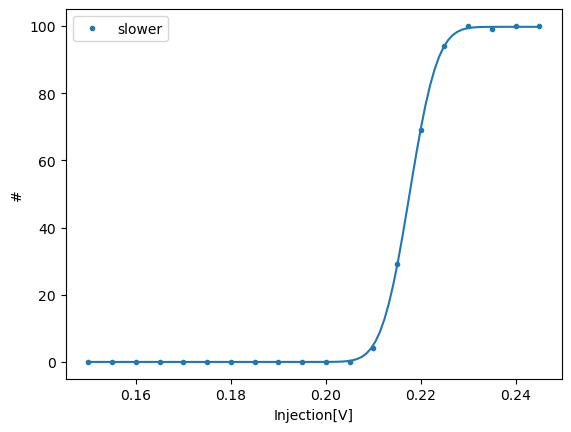

In [73]:
## get data from hit file (event_data)
with tb.open_file(fhit) as f:
    dat = f.root.event_data[:]
## get data from raw data (scan_parameters)
with tb.open_file(fraw) as f:
    param = f.root.scan_parameters[:]

## select hits from comparator0
dat0 = dat[dat['comp']==0]
if len(dat0)!=0:
    ## take only the first data (delete hits from the rising edges)
    uni, idx= np.unique(dat0['timestamp'], return_index=True)
    dat0 = dat0[idx]
    ## count hits per event_number
    nhit = np.bincount(dat0['event_number'])

    # make a plot (injection vs n of hits)
    plt.plot(param['inj'], nhit, '.', label='faster')

## select hits from comparator1
dat1 = dat[dat['comp']==1]
if len(dat1)!=0:
#print(dat1)
    uni, idx = np.unique(dat1['timestamp'], return_index=True)
    dat1 = dat1[idx]
    nhit1 = np.bincount(dat1['event_number']) #, minlength=len(param))
    fit = fitfunc.fit_scurve(param['inj'], nhit1, reverse=False)
    x = np.linspace(np.min(param['inj']), np.max(param['inj']), num=100)
    plt.plot(x, fitfunc.scurve(x,*fit[:3]), '-')
    plt.plot(param['inj'], nhit1, 'C0.', label='slower')

## show x-axis and y-axis and legend
plt.xlabel('Injection[V]')
plt.ylabel('#')
plt.legend()

## print threshold
print('th={0:.3f} th_sigma={1:.3f} Vinj'.format(fit[1], fit[2]))

## Timewalk 

100 12


(250.0, 375.0)

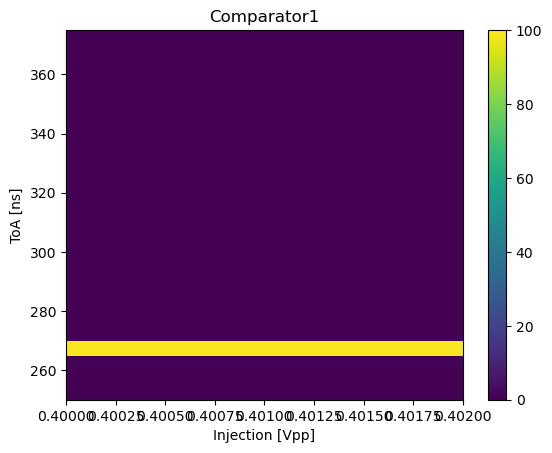

In [12]:
## timewalk
## define the 2D array
n = 100 #2**11
nsteps = param.shape[0]
print(n, nsteps)
toa = np.empty([n, nsteps])
# for each step (event_number)
for i in range(nsteps):
    ## select hit in each event_number
    ev = dat0[dat0['event_number']==i]
    tmp = np.array([
            ev['col']==col,
            ev['row']==row])
    ev = ev[np.all(tmp, axis=0)]
    ## make a histogram in each evevent
    toa[:,i] = np.bincount(ev['toa'], minlength=n)[:n]
    #print(ev['toa'], toa[:, i])
    
# plot 
plt.imshow(toa, origin='lower', extent=(param['inj'][0]/10., param['inj'][-1]/10., 0, n*5), aspect='auto')
plt.xlabel('Injection [Vpp]')
plt.ylabel('ToA [ns]')
plt.title('Comparator1')
plt.colorbar()
plt.xlim(0.4, 0.4+0.0020)
plt.ylim(250, 375)

#### text text text

Text(0.5, 1.0, 'Comparator2')

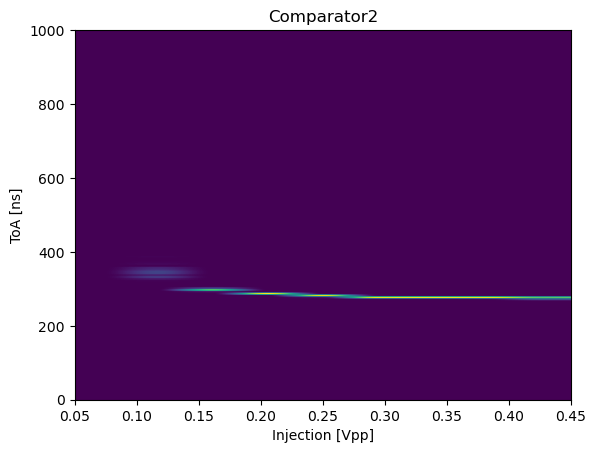

In [18]:
## timewalk
n = 200 #2**11
nsteps = param.shape[0]
toa = np.empty([n, nsteps])
for i in range(nsteps):
    ev = dat1[dat1['event_number']==i]
    tmp = np.array([
            ev['col']==col,
            ev['row']==row])
    ev = ev[np.all(tmp, axis=0)]
    toa[:,i] = np.bincount(ev['toa'], minlength=n)[:n]

plt.imshow(toa, origin='lower', extent=(param['inj'][0]/10., param['inj'][-1]/10., 0, n*5), aspect='auto')
plt.xlabel('Injection [Vpp]')
plt.ylabel('ToA [ns]')
plt.title('Comparator2')